In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from imblearn.over_sampling import SMOTE

# Prepare Data

In [2]:
df = pd.read_csv("../input/geneall-data-filtered/GeneALL_Data_filtered.csv")

In [3]:
df = pd.read_csv("../input/geneall-data-filtered/GeneALL_Data_filtered.csv").drop(["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1","ID"], axis=1)

In [4]:
df['Group'].replace('  ', np.nan, inplace=True)
df= df.dropna(subset=['Group'])

# Encode categorical data 

In [5]:
#CN 1, AD 0, MCI 2
#M 1, F 0
label_encoder = LabelEncoder()
df["Group"]= label_encoder.fit_transform(df["Group"])
df["Sex"]= label_encoder.fit_transform(df["Sex"])

In [6]:
features = df.drop('Group',axis=1)
label= df.Group

In [7]:
x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.2,stratify=label,random_state = 42)

# Class weights 

In [11]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
print(class_weights)
class_weights_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
print(class_weights_dict)

class_weights_1 = class_weight.compute_sample_weight(class_weight = 'balanced' , y = np.array(y_train))
print(class_weights_1)

# # # class_weights_dict = {0: 2, 1: 2, 2: 1}


[1.4468599  1.1745098  0.68613975]
{0: 1.4468599033816425, 1: 1.1745098039215687, 2: 0.6861397479954181}
[1.4468599  0.68613975 0.68613975 0.68613975 0.68613975 1.1745098
 1.1745098  0.68613975 1.1745098  1.4468599  1.1745098  0.68613975
 1.1745098  1.1745098  1.4468599  0.68613975 1.4468599  0.68613975
 1.1745098  0.68613975 1.4468599  0.68613975 1.4468599  0.68613975
 1.1745098  0.68613975 0.68613975 0.68613975 0.68613975 1.4468599
 0.68613975 0.68613975 1.1745098  0.68613975 0.68613975 0.68613975
 0.68613975 1.1745098  1.1745098  0.68613975 0.68613975 0.68613975
 0.68613975 1.1745098  0.68613975 1.4468599  0.68613975 0.68613975
 0.68613975 0.68613975 0.68613975 0.68613975 1.1745098  0.68613975
 0.68613975 1.1745098  0.68613975 1.1745098  1.4468599  0.68613975
 1.4468599  0.68613975 0.68613975 1.1745098  1.1745098  1.4468599
 1.4468599  0.68613975 0.68613975 1.4468599  0.68613975 1.4468599
 0.68613975 1.1745098  1.1745098  1.4468599  1.1745098  1.1745098
 1.4468599  1.4468599  1.1745

# GBTrees classifier 

In [12]:
GBTkfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
hyperparameters = {"learning_rate" : [0.1, 0.2, 0.3], "n_estimators" : [100,300,500,700,900], "criterion" : ['friedman_mse', 'squared_error'], "min_samples_split" : [2,4,6,8,10],"min_samples_leaf": [1,2,3], "max_depth": [3, 6, 9,12]}

bestModelFound = GridSearchCV(GradientBoostingClassifier(random_state=42),hyperparameters,scoring='accuracy',cv=GBTkfold,n_jobs=-1)
bestModelFound.fit(x_train,y_train, sample_weight = class_weights_1)
print("The best score found is:",bestModelFound.best_score_)

best_learning_rate= bestModelFound.best_params_.get("learning_rate")
print("best learning rate:",best_learning_rate)

bestNestimators = bestModelFound.best_params_.get("n_estimators")
print("The best N estimators is:",bestNestimators)

bestCriterion = bestModelFound.best_params_.get("criterion")
print("The best Criterion is:",bestCriterion)

bestMinSampleSplit = bestModelFound.best_params_.get("min_samples_split")
print("The best Min sample split is:",bestMinSampleSplit)
                                            
bestMinSampleLeaf = bestModelFound.best_params_.get("min_samples_leaf")
print("The best Min sample Leaf is:",bestMinSampleLeaf)
                                            
bestMaxDepth = bestModelFound.best_params_.get("max_depth")
print("The best Max Depth is:",bestMaxDepth)

results = cross_val_score(GradientBoostingClassifier(n_estimators=bestNestimators, learning_rate=best_learning_rate, max_depth=bestMaxDepth,criterion=bestCriterion,min_samples_split=bestMinSampleSplit, min_samples_leaf=bestMinSampleLeaf, random_state=42), x_train, y_train, cv = GBTkfold)
print("Cross val score : ", results)
print("accuracy is : ", results.mean()*100)

The best score found is: 0.48912429378531075
best learning rate: 0.3
The best N estimators is: 100
The best Criterion is: friedman_mse
The best Min sample split is: 4
The best Min sample Leaf is: 1
The best Max Depth is: 9
Cross val score :  [0.4        0.45       0.46666667 0.43333333 0.56666667 0.48333333
 0.45       0.5        0.36666667 0.37288136]
accuracy is :  44.89548022598869


In [13]:
gbt = GradientBoostingClassifier(n_estimators=bestNestimators, learning_rate=best_learning_rate, max_depth=bestMaxDepth,criterion=bestCriterion,min_samples_split=bestMinSampleSplit, min_samples_leaf=bestMinSampleLeaf, random_state=42)

In [14]:
gbt.fit(x_train, y_train, sample_weight = class_weights_1 )

GradientBoostingClassifier(learning_rate=0.3, max_depth=9, min_samples_split=4,
                           random_state=42)

In [15]:
gbt_predict = gbt.predict(x_test)

# Random Forest 

In [16]:
RF = RandomForestClassifier(n_estimators = 300, criterion = "gini", max_depth = 20, max_features = "auto", min_samples_split = 3, min_samples_leaf = 2, random_state = 42, class_weight = class_weights_dict)

In [17]:
RF.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 1.4468599033816425,
                                     1: 1.1745098039215687,
                                     2: 0.6861397479954181},
                       max_depth=20, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=300, random_state=42)

In [18]:
RF_predict = RF.predict(x_test)

# XGBoost 

In [19]:
xb = xgb.XGBClassifier(min_child_weight = 3, gamma= 0, max_depth = 5, subsample = 1, random_state=42)

In [20]:
xb.fit(x_train, y_train, sample_weight = class_weights_1 )

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [21]:
xb_predict = xb.predict(x_test)

# compare predictions 

[2 0 2 2 1 0 1 2 2 0 2 1 0 1 0 2 2 2 2 2 1 2 2 1 1 1 2 1 1 2 1 1 2 2 2 0 0
 0 1 1 2 2 1 0 1 1 2 2 1 1 1 0 0 2 2 1 0 2 2 2 2 0 2 0 2 0 2 2 2 2 1 1 0 1
 1 0 0 2 2 2 0 2 2 2 2 1 0 2 2 0 0 2 2 2 0 2 1 0 0 0 2 2 0 1 0 2 2 2 2 1 1
 2 2 2 2 0 2 0 2 2 2 1 2 1 2 1 1 1 2 1 1 2 0 0 2 2 2 2 0 1 0 1 2 1 2 0 1 1
 2 2]
GBT PREDICT: [1 2 2 0 2 1 2 0 2 2 2 1 1 2 2 1 2 0 2 2 1 1 2 1 2 1 2 2 2 2 1 0 1 2 2 2 1
 1 1 2 1 1 1 1 2 1 2 0 1 2 2 2 2 0 2 2 2 2 2 1 2 0 2 0 1 1 2 0 1 2 2 2 2 1
 1 0 2 2 2 1 2 1 1 2 0 2 0 0 1 2 0 2 1 2 0 2 2 2 2 2 0 1 2 2 2 1 2 0 2 1 1
 0 2 2 1 1 2 0 2 2 1 2 1 1 1 2 0 2 2 1 1 0 2 0 2 1 2 1 2 0 2 2 2 1 1 2 1 2
 2 1]
accruracy score is :  0.42
RF PREDICT: [2 2 2 2 2 2 2 0 2 2 2 1 1 2 2 1 2 0 2 2 0 1 2 1 2 0 2 2 2 2 1 0 2 2 2 2 1
 0 1 1 1 2 2 1 2 0 2 2 1 2 1 2 2 0 2 1 2 2 1 2 1 0 2 0 1 1 2 2 1 2 2 2 0 2
 1 0 2 2 2 1 0 2 1 2 0 2 2 2 2 0 2 2 2 2 0 2 1 2 1 2 2 2 1 2 1 2 2 0 2 2 2
 2 2 1 1 1 2 2 2 2 2 2 2 2 1 2 1 2 0 1 1 2 2 0 2 1 2 1 2 0 2 2 2 1 1 2 1 0
 1 1]
accruracy score is :  0.493333

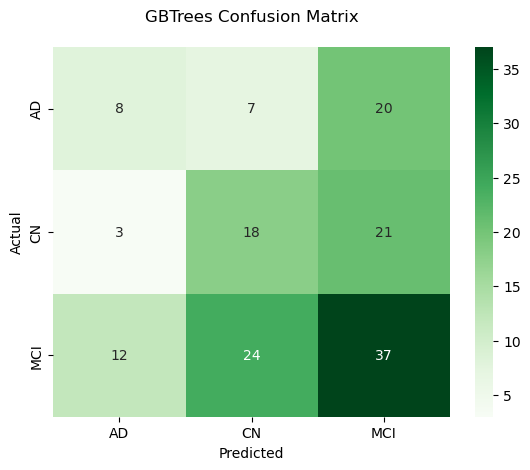

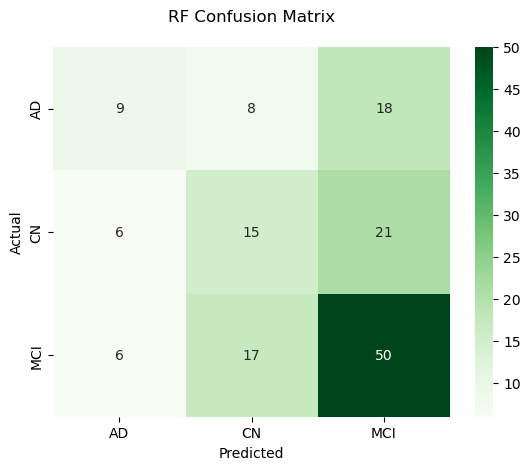

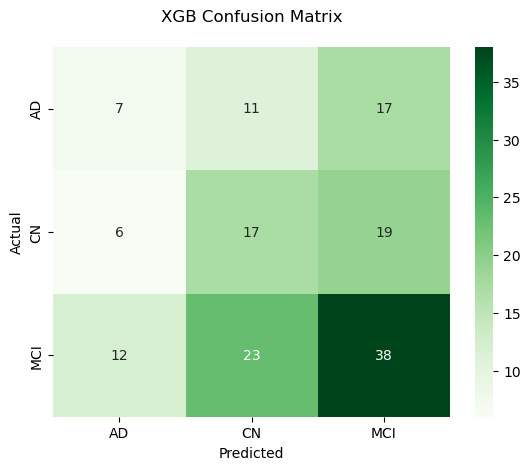

In [22]:
print(np.array(y_test))
print("GBT PREDICT:", gbt_predict)
print("accruracy score is : " , accuracy_score(np.array(y_test), gbt_predict)) 


print("RF PREDICT:", RF_predict)
print("accruracy score is : " , accuracy_score(np.array(y_test), RF_predict)) 


print("XGB PREDICT:", xb_predict)
print("accruracy score is : " , accuracy_score(np.array(y_test), xb_predict)) 


label_name=["AD","CN","MCI"]
ConfusionMatrix = confusion_matrix(np.array(y_test),np.array(gbt_predict))
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("GBTrees Confusion Matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


label_name=["AD","CN","MCI"]
ConfusionMatrix = confusion_matrix(np.array(y_test),np.array(RF_predict))
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("RF Confusion Matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


label_name=["AD","CN","MCI"]
ConfusionMatrix = confusion_matrix(np.array(y_test),np.array(xb_predict))
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("XGB Confusion Matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 3 classifiers Voting 

In [23]:
predict_voting = []
for i in range (len(gbt_predict)): 
    voting_list =[0, 0, 0]
    if gbt_predict[i] == 0:
         voting_list[0] += 1
    elif gbt_predict[i] == 1:
         voting_list[1] += 1
    elif gbt_predict[i] == 2:
         voting_list[2] += 1
            
    if RF_predict[i] == 0:
         voting_list[0] += 1
    elif RF_predict[i] == 1:
         voting_list[1] += 1
    elif RF_predict[i] == 2:
         voting_list[2] += 1
            
    if xb_predict[i] == 0:
         voting_list[0] += 1
    elif xb_predict[i] == 1:
         voting_list[1] += 1
    elif xb_predict[i] == 2:
         voting_list[2] += 1
            
    predict_voting.append(np.argmax(voting_list))
    

print("The predicted labels of the combined models are:",predict_voting)
print("The accuracy score of the combined models is",accuracy_score(np.array(y_test),np.array(predict_voting))*100)

The predicted labels of the combined models are: [1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 2, 2, 0, 1, 1, 0, 2, 2, 2, 1, 0, 1, 1, 2, 0, 2, 2, 2, 1, 0, 2, 2, 1, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1]
The accuracy score of the combined models is 43.333333333333336


# Confusion matrix 

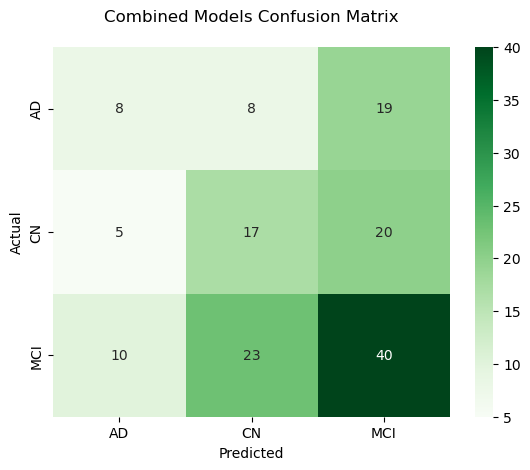

In [24]:
label_name=["AD","CN","MCI"]
ConfusionMatrix = confusion_matrix(np.array(y_test),np.array(predict_voting))
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("Combined Models Confusion Matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report 

In [25]:
print("Classification Report of the Combined Models\n")
print(classification_report(np.array(y_test),np.array(predict_voting), target_names=["AD","CN","MCI"]))

Classification Report of the Combined Models

              precision    recall  f1-score   support

          AD       0.35      0.23      0.28        35
          CN       0.35      0.40      0.38        42
         MCI       0.51      0.55      0.53        73

    accuracy                           0.43       150
   macro avg       0.40      0.39      0.39       150
weighted avg       0.43      0.43      0.43       150

